In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler

np.random.seed(123)
tf.random.set_seed(123)


# Get Data

In [2]:
T = 128
Ntrain = 7352
Ntest = 2947
D = 9 # 9 files
K = 6 # 6 Classes


def load_data():
    # returns:
    # Xtrain (Ntrain x T x D), Ytrain (Ntrain)
    # Xtest (Ntest x T x D), Ytest (Ntest)
    
    Xtrain = np.zeros((Ntrain, T, D))
    Xtest = np.zeros((Ntest, T, D))
    
    
    
    ##### train data
    ts_filenames = [
        'body_acc_x_train.txt', 'body_gyro_x_train.txt', 'total_acc_x_train.txt',
        'body_acc_y_train.txt', 'body_gyro_y_train.txt', 'total_acc_y_train.txt',
        'body_acc_z_train.txt', 'body_gyro_z_train.txt', 'total_acc_z_train.txt'
    ]
    
    ts_file_prefix = '../Data/UCI HAR Dataset/train/'
    
    for d, fn in enumerate(ts_filenames):
        df = pd.read_csv(
            f'{ts_file_prefix}Inertial Signals/{fn}',
            header = None,
            delim_whitespace = True
        )
        
        # Ntrain x T array
        x = df.to_numpy()
        Xtrain[:, :, d] = x
        
    
    # train labels
    Ytrain = pd.read_csv(
        f'{ts_file_prefix}y_train.txt',
            header = None).to_numpy() -1
    Ytrain = Ytrain.flatten()
    
    
    
    ##### test data
    ts_filenames = [
        'body_acc_x_test.txt', 'body_gyro_x_test.txt', 'total_acc_x_test.txt',
        'body_acc_y_test.txt', 'body_gyro_y_test.txt', 'total_acc_y_test.txt',
        'body_acc_z_test.txt', 'body_gyro_z_test.txt', 'total_acc_z_test.txt'
    ]
    ts_file_prefix = '../Data/UCI HAR Dataset/test/'

    for d, fn in enumerate(ts_filenames):
        df = pd.read_csv(
            f'{ts_file_prefix}Inertial Signals/{fn}',
            header = None,
            delim_whitespace = True
        )
        
        # Ntest x T array
        x = df.to_numpy()
        Xtest[:, :, d] = x
        
    # test labels
    Ytest = pd.read_csv(
        f'{ts_file_prefix}y_test.txt',
            header = None).to_numpy() -1
    Ytest = Ytest.flatten()
    
    
    return Xtrain, Ytrain, Xtest, Ytest

In [3]:
Xtrain, Ytrain, Xtest, Ytest = load_data()

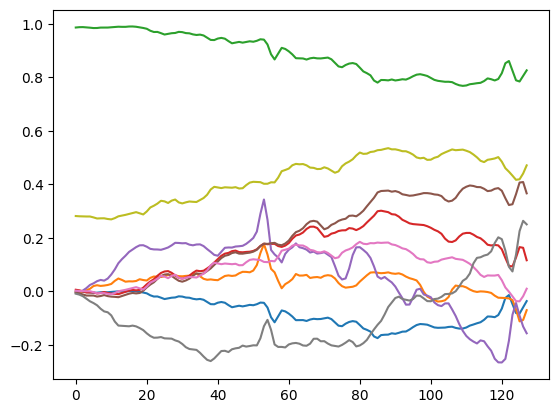

In [4]:
plt.plot(Xtrain[7000, :, :]);

# ANN Start

In [5]:
inputs = []
features = []

# Make NN for each of the D time series

for d in range(D):
    i = Input(shape = (T,))
    x = Dense(32, activation = 'relu')(i)
    x = Dense(16, activation = 'relu')(x)
    
    inputs.append(i)
    features.append(x)
    
# Output of concatenate will be D * (size of individual ANN output: 16)
x = Concatenate()(features)
x = Dense(K)(x)
model = Model(inputs, x)

# To save the best model
check_point = ModelCheckpoint(
    'best_model.h5', monitor = 'val_accuracy', save_best_only = True)

Metal device set to: Apple M1 Pro


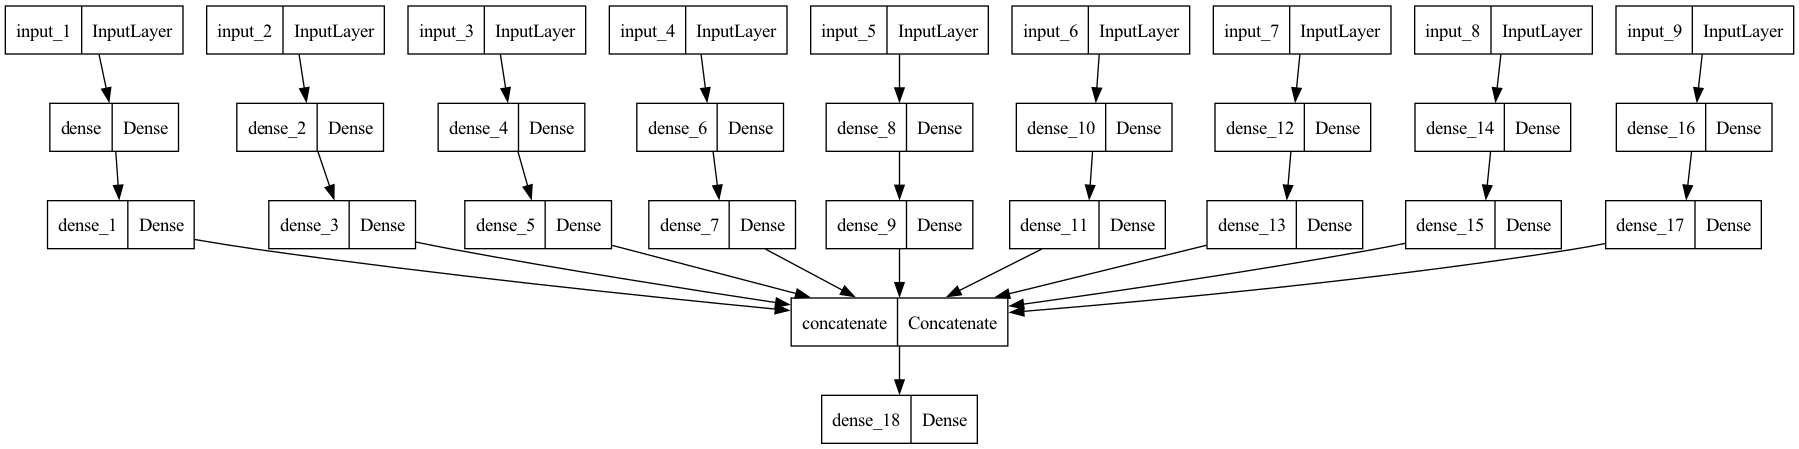

In [7]:
# Multi-tailed NN
tf.keras.utils.plot_model(model)

In [14]:
model.compile(
    loss = SparseCategoricalCrossentropy(from_logits = True),
    optimizer = 'adam',
    metrics = ['accuracy'],
)

Xtrain_split = []
Xtest_split = []

for d in range(D):
    Xtrain_split.append(Xtrain[:, :, d])
    Xtest_split.append(Xtest[:, :, d])

r = model.fit(
    Xtrain_split,
    Ytrain,
    epochs = 15,
    callbacks = [check_point],
    validation_data = (Xtest_split, Ytest)


Epoch 1/15


2023-09-17 12:34:24.743513: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


230/230 [==============================] - 7s 21ms/step - loss: 0.6327 - accuracy: 0.7916 - val_loss: 0.4484 - val_accuracy: 0.8283
Epoch 2/15
230/230 [==============================] - 4s 19ms/step - loss: 0.2265 - accuracy: 0.9204 - val_loss: 0.3371 - val_accuracy: 0.8707
Epoch 3/15
230/230 [==============================] - 4s 18ms/step - loss: 0.1643 - accuracy: 0.9425 - val_loss: 0.3128 - val_accuracy: 0.8802
Epoch 4/15
230/230 [==============================] - 4s 19ms/step - loss: 0.1364 - accuracy: 0.9475 - val_loss: 0.2891 - val_accuracy: 0.8904
Epoch 5/15
230/230 [==============================] - 4s 18ms/step - loss: 0.1188 - accuracy: 0.9584 - val_loss: 0.2640 - val_accuracy: 0.8935
Epoch 6/15
230/230 [==============================] - 4s 19ms/step - loss: 0.1045 - accuracy: 0.9634 - val_loss: 0.2704 - val_accuracy: 0.8884
Epoch 7/15
230/230 [==============================] - 4s 18ms/step - loss: 0.0946 - accuracy: 0.9674 - val_loss: 0.2612 - val_accuracy: 0.8996
Epoch 8/15

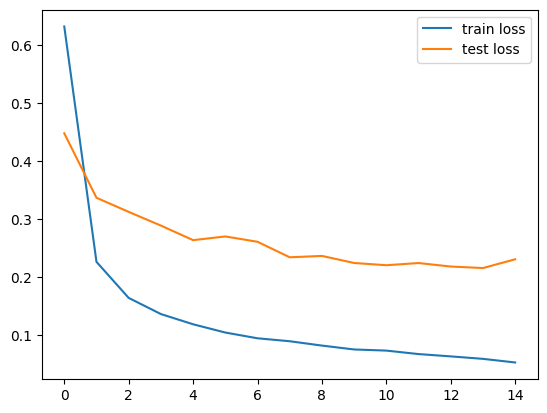

In [15]:
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'test loss')
plt.legend();

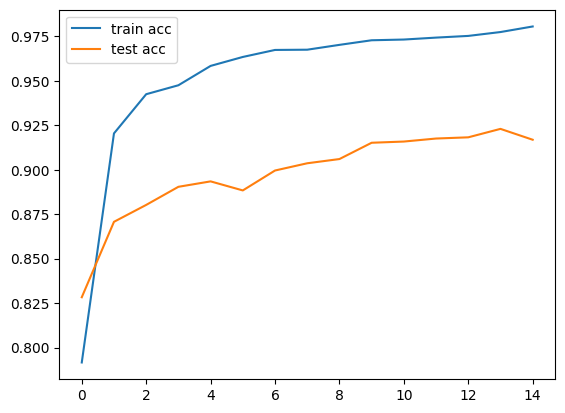

In [16]:
plt.plot(r.history['accuracy'], label = 'train acc')
plt.plot(r.history['val_accuracy'], label = 'test acc')
plt.legend();

In [23]:
# Load the best model
best_model = tf.keras.models.load_model('best_model.h5')

# make predictions
Ptest = best_model.predict(Xtest_split)

# evauluate
np.mean(np.argmax(Ptest, axis = 1) == Ytest)

93/93 [==============================] - 1s 6ms/step


0.9229725144214456

# Feature based model

In [32]:
def load_features():
    df = pd.read_csv(
        '../Data/UCI HAR Dataset/train/X_train.txt',
        header = None,
        delim_whitespace = True
    )
    feat_train = df.to_numpy()
    
    # test data
    df = pd.read_csv(
        '../Data/UCI HAR Dataset/test/X_test.txt',
        header = None,
        delim_whitespace = True
    )
    feat_test = df.to_numpy()
    
    scaler = StandardScaler()
    feat_train = scaler.fit_transform(feat_train)
    feat_test = scaler.transform(feat_test)
    
    return feat_train, feat_test


feat_train, feat_test = load_features()

D_feat = feat_train.shape[1]

In [34]:
# Basic ANN
i = Input(shape = (D_feat,))
x = Dense(32, activation = 'relu')(i)
x = Dense(K)(x)
model = Model(i, x)

# To save the best model
check_point2 = ModelCheckpoint(
    'best_model.h5', monitor = 'val_accuracy', save_best_only = True)

model.compile(
    loss = SparseCategoricalCrossentropy(from_logits = True),
    optimizer = 'adam',
    metrics = ['accuracy'],
)

r = model.fit(
    feat_train,
    Ytrain,
    epochs = 15,
    callbacks = [check_point2],
    validation_data = (feat_test, Ytest)
)

Epoch 1/15
230/230 [==============================] - 2s 8ms/step - loss: 0.3299 - accuracy: 0.8755 - val_loss: 0.2130 - val_accuracy: 0.9216
Epoch 2/15
230/230 [==============================] - 2s 8ms/step - loss: 0.1102 - accuracy: 0.9638 - val_loss: 0.1647 - val_accuracy: 0.9399
Epoch 3/15
230/230 [==============================] - 2s 7ms/step - loss: 0.0780 - accuracy: 0.9713 - val_loss: 0.1575 - val_accuracy: 0.9376
Epoch 4/15
230/230 [==============================] - 2s 7ms/step - loss: 0.0608 - accuracy: 0.9778 - val_loss: 0.1805 - val_accuracy: 0.9338
Epoch 5/15
230/230 [==============================] - 2s 8ms/step - loss: 0.0517 - accuracy: 0.9814 - val_loss: 0.1602 - val_accuracy: 0.9423
Epoch 6/15
230/230 [==============================] - 2s 8ms/step - loss: 0.0438 - accuracy: 0.9850 - val_loss: 0.1627 - val_accuracy: 0.9437
Epoch 7/15
230/230 [==============================] - 2s 7ms/step - loss: 0.0427 - accuracy: 0.9849 - val_loss: 0.1948 - val_accuracy: 0.9369
Epoch 

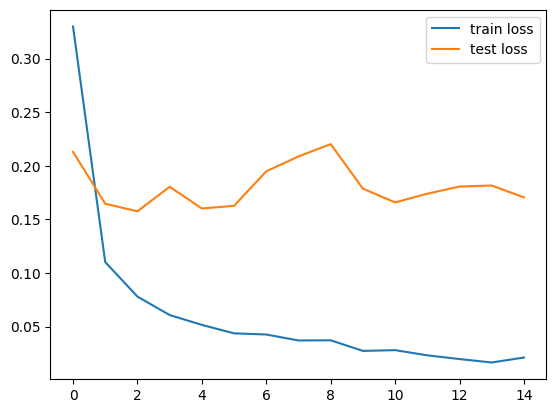

In [35]:
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'test loss')
plt.legend();

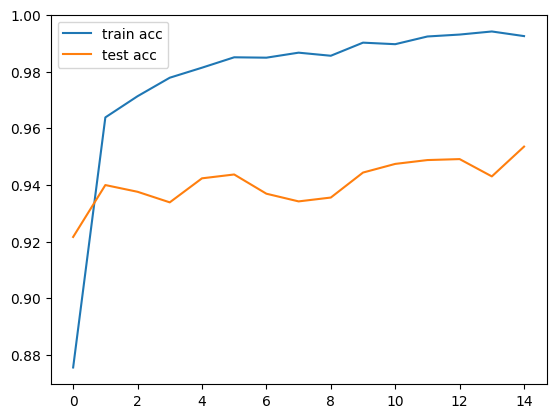

In [36]:
plt.plot(r.history['accuracy'], label = 'train acc')
plt.plot(r.history['val_accuracy'], label = 'test acc')
plt.legend();

In [38]:
# Load the best model
best_model = tf.keras.models.load_model('best_model.h5')

# make predictions
Ptest = best_model.predict(feat_test)

# evauluate
np.mean(np.argmax(Ptest, axis = 1) == Ytest)

93/93 [==============================] - 0s 2ms/step


0.9535120461486257

In [40]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

### Logistic

In [41]:
model = LogisticRegression(solver = 'liblinear')
model.fit(feat_train, Ytrain)
print("Train:",model.score(feat_train, Ytrain))
print("Test:",model.score(feat_test, Ytest))

0.9945593035908596

### SVM

In [43]:
model = SVC()
model.fit(feat_train, Ytrain)
print("Train:",model.score(feat_train, Ytrain))
print("Test:",model.score(feat_test, Ytest))

Train: 0.9866702937976061
Test: 0.9521547336274178


In [44]:
model = SVC(kernel = 'linear')
model.fit(feat_train, Ytrain)
print("Train:",model.score(feat_train, Ytrain))
print("Test:",model.score(feat_test, Ytest))

Train: 0.9968715995647442
Test: 0.9609772650152698


### RF

In [45]:
model = RandomForestClassifier()
model.fit(feat_train, Ytrain)
print("Train:",model.score(feat_train, Ytrain))
print("Test:",model.score(feat_test, Ytest))

Train: 1.0
Test: 0.9307770614183916


# Combined Model

In [47]:
# combined model
inputs = []
features = []

for d in range(D):
    i = Input(shape = (T,))
    x = Dense(32, activation = 'relu')(i)
    x = Dense(16, activation = 'relu')(x)
    
    inputs.append(i)
    features.append(x)
    
i2 = Input(shape = (D_feat,))
x2 = Dense(32, activation = 'relu')(i2)

# output of concatenated will be D * (size of individual ANN output)
x = Concatenate()(features + [x2])
x = Dense(K)(x)
model = Model(inputs + [i2], x)


# To save the best model
check_point3 = ModelCheckpoint(
    'best_model_combined.h5', monitor = 'val_accuracy', save_best_only = True)


model.compile(
    loss = SparseCategoricalCrossentropy(from_logits = True),
    optimizer = 'adam',
    metrics = ['accuracy'],
)

r = model.fit(
    Xtrain_split + [feat_train],
    Ytrain,
    epochs = 15,
    callbacks = [check_point3],
    validation_data = (Xtest_split + [feat_test], Ytest)
)

Epoch 1/15
230/230 [==============================] - 6s 23ms/step - loss: 0.2864 - accuracy: 0.9014 - val_loss: 0.2136 - val_accuracy: 0.9206
Epoch 2/15
230/230 [==============================] - 5s 20ms/step - loss: 0.0933 - accuracy: 0.9691 - val_loss: 0.1730 - val_accuracy: 0.9389
Epoch 3/15
230/230 [==============================] - 5s 20ms/step - loss: 0.0677 - accuracy: 0.9754 - val_loss: 0.1613 - val_accuracy: 0.9444
Epoch 4/15
230/230 [==============================] - 4s 19ms/step - loss: 0.0558 - accuracy: 0.9788 - val_loss: 0.1867 - val_accuracy: 0.9372
Epoch 5/15
230/230 [==============================] - 4s 19ms/step - loss: 0.0495 - accuracy: 0.9812 - val_loss: 0.1361 - val_accuracy: 0.9532
Epoch 6/15
230/230 [==============================] - 4s 19ms/step - loss: 0.0395 - accuracy: 0.9864 - val_loss: 0.1483 - val_accuracy: 0.9494
Epoch 7/15
230/230 [==============================] - 4s 19ms/step - loss: 0.0386 - accuracy: 0.9865 - val_loss: 0.1625 - val_accuracy: 0.9501

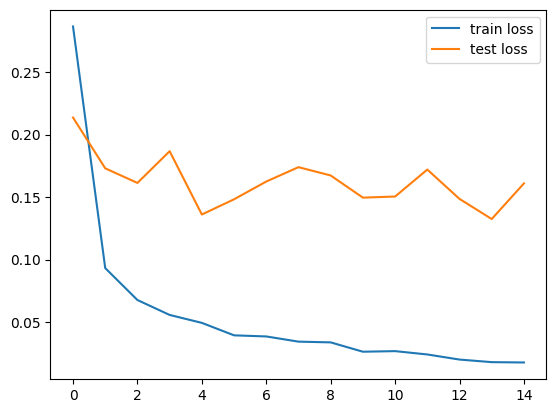

In [48]:
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'test loss')
plt.legend();

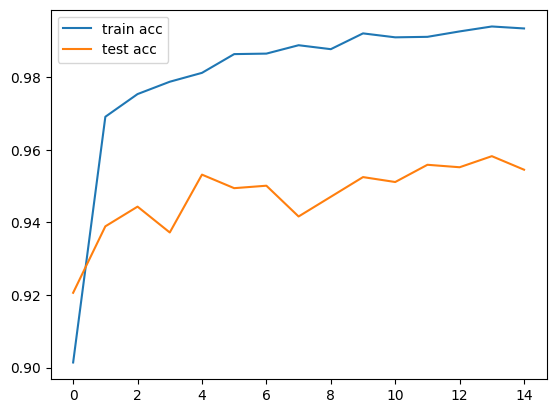

In [49]:
plt.plot(r.history['accuracy'], label = 'train acc')
plt.plot(r.history['val_accuracy'], label = 'test acc')
plt.legend();

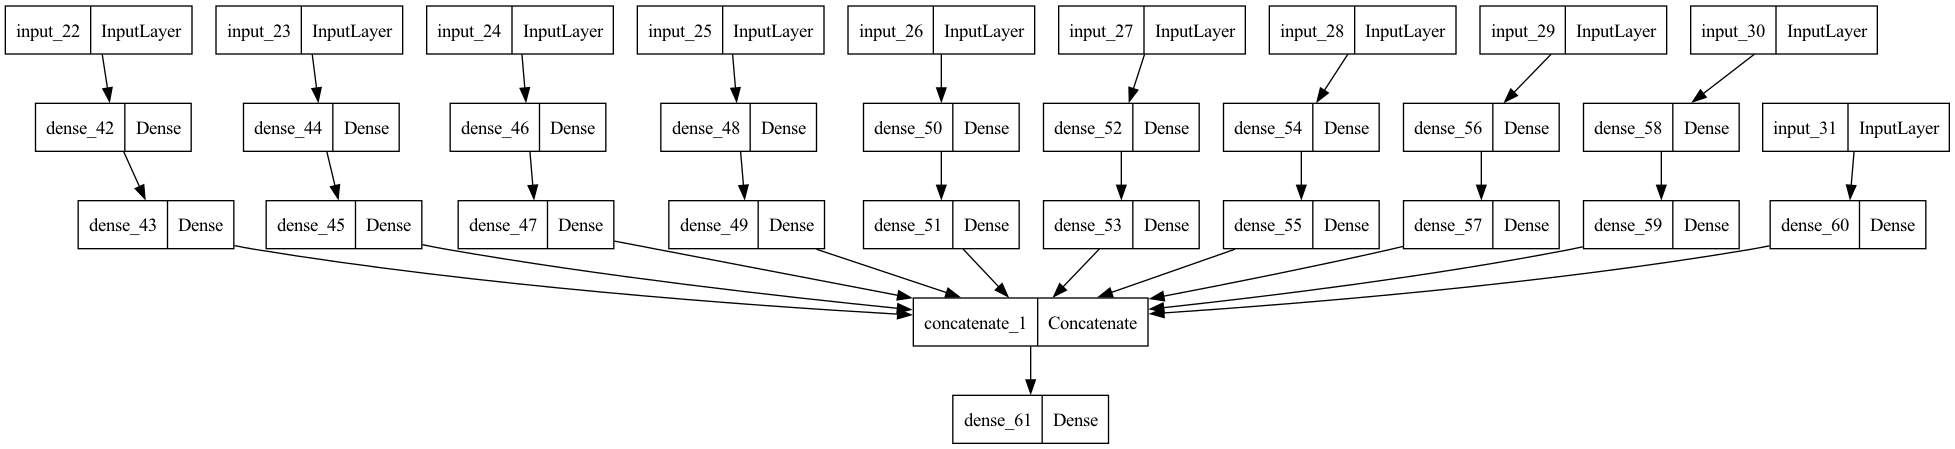

In [50]:
tf.keras.utils.plot_model(model)